In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [2]:
def f(x):
    return x**4 + 2*x**2 + 1

def grad_f(x):
    return 4*x**3 + 4*x

In [3]:
def gradient_descent_const(x0, eta, tol=1e-6, max_iter=1000):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    
    for _ in range(max_iter):
        x_new = x - eta * grad_f(x)
        x_vals.append(x_new)
        f_vals.append(f(x_new))
        
        if abs(x_new - x) < tol:
            break
        
        x = x_new
        
    return {
        "x_vals": np.array(x_vals),
        "f_vals": np.array(f_vals)
    }

In [4]:
def gradient_descent_backtrack(x0, alpha=0.5, beta=0.8, tol=1e-6, max_iter=1000):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    etas = []
    
    for _ in range(max_iter):
        grad = grad_f(x)
        eta = 1.0
        
        while f(x - eta * grad) > f(x) - alpha * eta * grad**2:
            eta *= beta
        
        etas.append(eta)
        x_new = x - eta * grad
        
        x_vals.append(x_new)
        f_vals.append(f(x_new))
        
        if abs(x_new - x) < tol:
            break
        
        x = x_new
        
    return {
        "x_vals": np.array(x_vals),
        "f_vals": np.array(f_vals),
        "etas": np.array(etas)
    }

In [5]:
res_const = gradient_descent_const(x0=1, eta=0.2)
res_bt = gradient_descent_backtrack(x0=1)

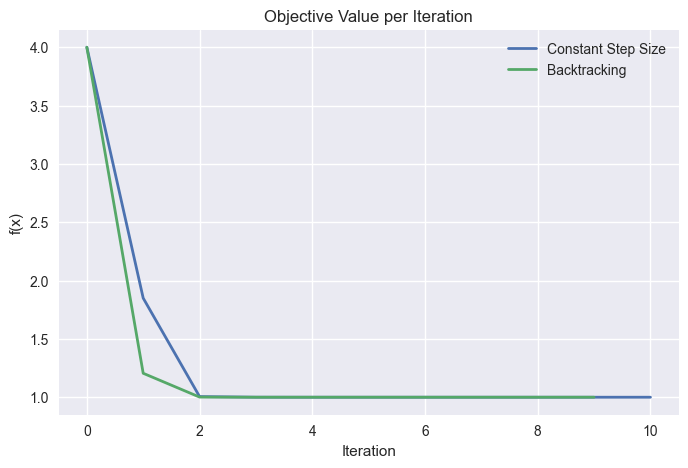

In [6]:
plt.figure(figsize=(8,5))
plt.plot(res_const["f_vals"], label="Constant Step Size", linewidth=2)
plt.plot(res_bt["f_vals"], label="Backtracking", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("f(x)")
plt.title("Objective Value per Iteration")
plt.legend()
plt.show()

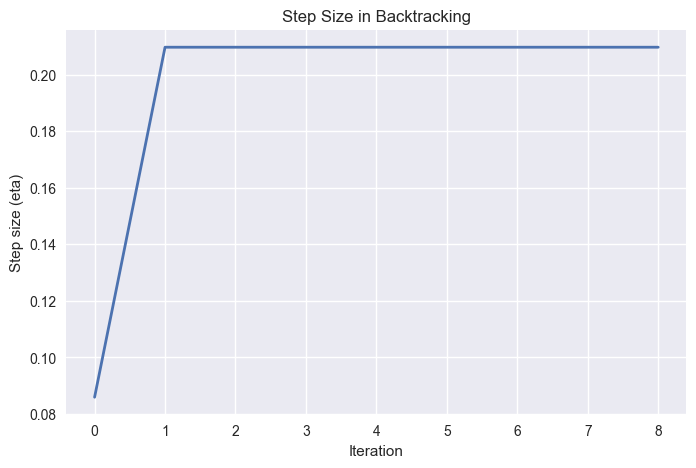

In [7]:
plt.figure(figsize=(8,5))
plt.plot(res_bt["etas"], linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Step size (eta)")
plt.title("Step Size in Backtracking")
plt.show()

In [8]:
data1 = pd.read_csv("dataset1.csv")
data2 = pd.read_csv("dataset2.csv")

In [9]:
def gradient_descent(X, y, eta=0.01, tol=1e-6, max_iter=10000,
                     backtracking=True, alpha=0.5, beta_bt=0.8):
    
    n, p = X.shape
    beta = np.zeros(p)
    obj_values = []
    
    def obj(beta):
        return np.sum((X @ beta - y)**2) / (2*n)
    
    def grad(beta):
        return (X.T @ (X @ beta - y)) / n
    
    for _ in range(max_iter):
        g = grad(beta)
        t = eta
        
        if backtracking:
            while obj(beta - t*g) > obj(beta) - alpha*t*np.dot(g, g):
                t *= beta_bt
        
        beta_new = beta - t*g
        obj_values.append(obj(beta_new))
        
        if np.linalg.norm(beta_new - beta) < tol:
            break
        
        beta = beta_new
    
    return {
        "beta": beta,
        "obj_values": np.array(obj_values)
    }

In [10]:
X1 = np.c_[np.ones(len(data1)), data1.iloc[:,1:].values]
y1 = data1.iloc[:,0].values

X2 = np.c_[np.ones(len(data2)), data2.iloc[:,1:].values]
y2 = data2.iloc[:,0].values

In [11]:
gd1_const = gradient_descent(X1, y1, eta=0.8, backtracking=False)
gd1_bt = gradient_descent(X1, y1)

gd2_const = gradient_descent(X2, y2, eta=0.01, backtracking=False)
gd2_bt = gradient_descent(X2, y2)

In [12]:
beta_ols1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
beta_ols2 = np.linalg.lstsq(X2, y2, rcond=None)[0]

np.linalg.norm(gd1_const["beta"] - beta_ols1)
np.linalg.norm(gd1_bt["beta"] - beta_ols1)

np.linalg.norm(gd2_const["beta"] - beta_ols2)
np.linalg.norm(gd2_bt["beta"] - beta_ols2)

np.float64(0.015043436984876186)

In [13]:
def gradient_descent_polyak(X, y, eta=0.01, mu=0.9, tol=1e-6, max_iter=10000,
                            backtracking=False, alpha=0.5, beta_bt=0.8):
    
    n, p = X.shape
    beta = np.zeros(p)
    beta_prev = beta.copy()
    obj_values = []
    
    def obj(beta):
        return np.sum((X @ beta - y)**2) / (2*n)
    
    def grad(beta):
        return (X.T @ (X @ beta - y)) / n
    
    for _ in range(max_iter):
        g = grad(beta)
        direction = -g + mu*(beta - beta_prev)
        t = eta
        
        if backtracking:
            while obj(beta + t*direction) > obj(beta) + alpha*t*np.dot(g, direction):
                t *= beta_bt
        
        beta_new = beta + t*direction
        obj_values.append(obj(beta_new))
        
        if np.linalg.norm(beta_new - beta) < tol:
            break
        
        beta_prev = beta
        beta = beta_new
    
    return {"beta": beta, "obj_values": np.array(obj_values)}